<div style="text-align: center; font-size: 20px; font-weight: bold;">
<h1>Skforecast: global models for multiple time series forecasting</h1>
</div>

**Autores**: Joaquin Amat Rodrigo, Javier Escobar Ortiz

**Fecha**: 28-11-2024

<br>

<div style="text-align: center;">
    <img src="https://github.com/JoaquinAmatRodrigo/skforecast/raw/master/docs/img/banner-landing-page-skforecast.png" style="display: block; margin: 0 auto;">
</div>

## Libraries

In [1]:
# Data manipulation
# ==============================================================================
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.model_selection import TimeSeriesFold

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

## Data

In [2]:
# Data download
# ==============================================================================
data = fetch_dataset(name="items_sales")
data.head()

items_sales
-----------
Simulated time series for the sales of 3 different items.
Simulated data.
Shape of the dataset: (1097, 3)


,item_1,item_2,item_3
date,,,
2012-01-01,8.253175,21.047727,19.429739
2012-01-02,22.777826,26.578125,28.009863
2012-01-03,27.549099,31.751042,32.078922
2012-01-04,25.895533,24.567708,27.252276
2012-01-05,21.379238,18.191667,20.357737


In [3]:
# Split data into train-val-test
# ==============================================================================
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 2012-01-01 00:00:00 --- 2014-07-15 00:00:00   (n=927)
Test dates  : 2014-07-16 00:00:00 --- 2015-01-01 00:00:00   (n=170)


## Graphic exploration

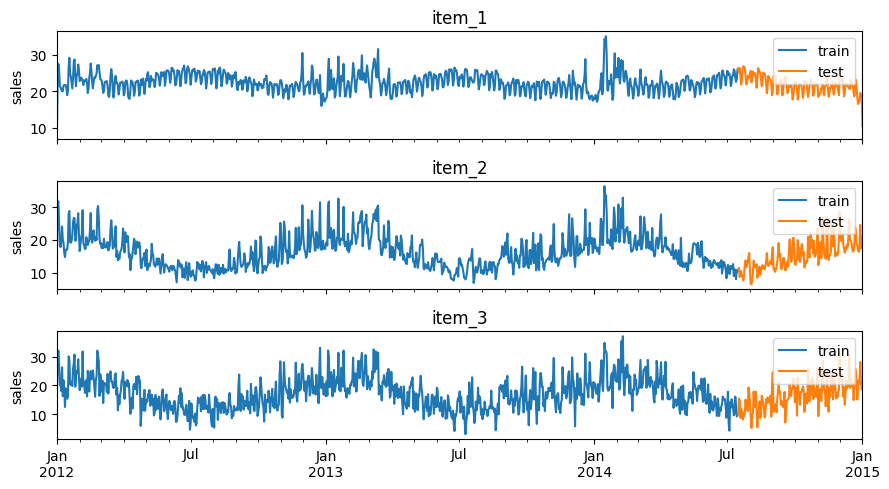

In [4]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 5), sharex=True)

for i, col in enumerate(data.columns):
    data_train[col].plot(ax=axes[i], label='train')
    data_test[col].plot(ax=axes[i], label='test')
    axes[i].set_title(col)
    axes[i].set_ylabel('sales')
    axes[i].set_xlabel('')
    axes[i].legend(loc='upper right')

fig.tight_layout()
plt.show();

## ForecasterRecursiveMultiSeries

In [5]:
# Create and train ForecasterRecursiveMultiSeries
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 window_features    = None,
                 encoding           = 'ordinal',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

forecaster.fit(series=data_train)
forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: None 
Window size: 24 
Series encoding: ordinal 
Series names (levels): item_1, item_2, item_3 
Exogenous included: False 
Exogenous names: None 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    'item_1': ['2012-01-01', '2014-07-15'], 'item_2': ['2012-01-01', '2014-07-15'],
    'item_3': ['2012-01-01', '2014-07-15'] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-11-26 11:33:46 
Last fit date: 2024-11-26 11:33:46 
Skforecast version: 0.14.0 
Python version: 3.11.10 
Forecaster id: None

In [6]:
# Internal training matrices
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(data.loc[:end_train, :])
display(X_train.head(3))
display(y_train.head(3))


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,_level_skforecast
date,,,,,,,,,,,,,,,,,,,,,
2012-01-25,28.018830,23.981037,20.794986,22.503533,24.018768,24.772249,29.245869,26.636444,20.228468,18.976196,...,20.006161,20.069327,20.533871,21.106643,21.379238,25.895533,27.549099,22.777826,8.253175,0
2012-01-26,28.747482,28.018830,23.981037,20.794986,22.503533,24.018768,24.772249,29.245869,26.636444,20.228468,...,21.620184,20.006161,20.069327,20.533871,21.106643,21.379238,25.895533,27.549099,22.777826,0
2012-01-27,23.908368,28.747482,28.018830,23.981037,20.794986,22.503533,24.018768,24.772249,29.245869,26.636444,...,21.717691,21.620184,20.006161,20.069327,20.533871,21.106643,21.379238,25.895533,27.549099,0


date
2012-01-25    28.747482
2012-01-26    23.908368
2012-01-27    21.423930
Name: y, dtype: float64

### Predict

In [7]:
# Predictions and prediction intervals
# ==============================================================================
steps = 24

# Predictions for item_1
predictions_item_1 = forecaster.predict(steps=steps, levels='item_1')
display(predictions_item_1.head(3))

,item_1
2014-07-16,25.906323
2014-07-17,25.807194
2014-07-18,25.127355


In [8]:
# Predictions for all items
predictions_all_items = forecaster.predict(steps=steps)

## Backtesting

In [9]:
# Backtesting multiple time series
# ==============================================================================
cv = TimeSeriesFold(
         steps                 = 24,
         initial_train_size    = len(data_train),
         refit                 = True,
         fixed_train_size      = True,
         allow_incomplete_fold = True
     )

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = data,
    exog                  = None,
    cv                    = cv,
    levels                = None,
    metric                = 'mean_absolute_error',
    add_aggregated_metric = True,
    n_jobs                = 'auto',
    verbose               = False,
    show_progress         = True,
    suppress_warnings     = False
)

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

  0%|          | 0/8 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error
0,item_1,1.158312
1,item_2,2.563145
2,item_3,3.322265
3,average,2.347908
4,weighted_average,2.347908
5,pooling,2.347908



Backtest predictions


,item_1,item_2,item_3
2014-07-16,25.906323,10.522491,12.034587
2014-07-17,25.807194,10.623789,10.503966
2014-07-18,25.127355,11.299802,12.206434
2014-07-19,23.902609,11.441606,12.618740


# Time series of diferent lengths and different exogenous variables

In [10]:
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict

In [11]:
# Data
# ==============================================================================
series = pd.read_csv(
    'https://raw.githubusercontent.com/skforecast/skforecast-datasets/main/data/demo_multi_series.csv'
)
exog = pd.read_csv(
    'https://raw.githubusercontent.com/skforecast/skforecast-datasets/main/data/demo_multi_series_exog.csv'
)

series['timestamp'] = pd.to_datetime(series['timestamp'])
exog['timestamp'] = pd.to_datetime(exog['timestamp'])

display(series.head())
print("")
display(exog.head())

,series_id,timestamp,value
0,id_1000,2016-01-01,1012.500694
1,id_1000,2016-01-02,1158.500099
2,id_1000,2016-01-03,983.000099
3,id_1000,2016-01-04,1675.750496
4,id_1000,2016-01-05,1586.250694


,series_id,timestamp,sin_day_of_week,cos_day_of_week,air_temperature,wind_speed
0,id_1000,2016-01-01,-0.433884,-0.900969,6.416639,4.040115
1,id_1000,2016-01-02,-0.974928,-0.222521,6.366474,4.530395
2,id_1000,2016-01-03,-0.781831,0.623490,6.555272,3.273064
3,id_1000,2016-01-04,0.000000,1.000000,6.704778,4.865404
4,id_1000,2016-01-05,0.781831,0.623490,2.392998,5.228913


In [12]:
# Transform series and exog to dictionaries
# ==============================================================================
series_dict = series_long_to_dict(
    data      = series,
    series_id = 'series_id',
    index     = 'timestamp',
    values    = 'value',
    freq      = 'D'
)

exog_dict = exog_long_to_dict(
    data      = exog,
    series_id = 'series_id',
    index     = 'timestamp',
    freq      = 'D'
)

c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\skforecast\preprocessing\preprocessing.py:424: MissingValuesWarning: Series 'id_1003' is incomplete. NaNs have been introduced after setting the frequency. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


In [13]:
# Drop some exogenous variables for series 'id_1000' and 'id_1003'
# ==============================================================================
exog_dict['id_1000'] = exog_dict['id_1000'].drop(columns=['air_temperature', 'wind_speed'])
exog_dict['id_1003'] = exog_dict['id_1003'].drop(columns=['cos_day_of_week'])

In [14]:
# Partition data in train and test
# ==============================================================================
end_train = '2016-07-31 23:59:00'

series_dict_train = {k: v.loc[: end_train,] for k, v in series_dict.items()}
exog_dict_train   = {k: v.loc[: end_train,] for k, v in exog_dict.items()}
series_dict_test  = {k: v.loc[end_train:,] for k, v in series_dict.items()}
exog_dict_test    = {k: v.loc[end_train:,] for k, v in exog_dict.items()}

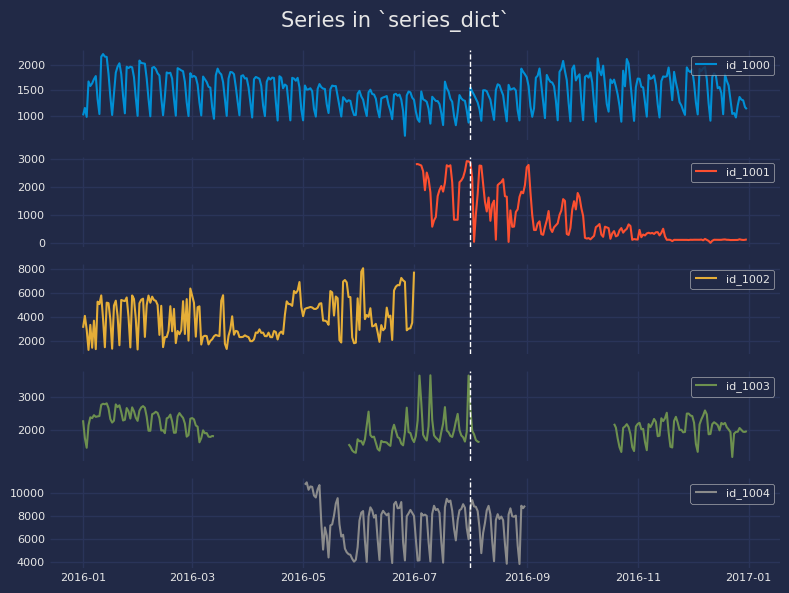

In [15]:
# Plot series
# ==============================================================================
set_dark_theme()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 6), sharex=True)

for i, s in enumerate(series_dict.values()):
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)
    axs[i].axvline(pd.to_datetime(end_train), color='white', linestyle='--', linewidth=1)  # End train

fig.suptitle('Series in `series_dict`', fontsize=15)
plt.tight_layout()

In [16]:
# Description of each partition
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(
            f"\tTrain: len={len(series_dict_train[k])}, {series_dict_train[k].index[0]}"
            f" --- {series_dict_train[k].index[-1]}"
        )
    except:
        print("\tTrain: len=0")
    try:
        print(
            f"\tTest : len={len(series_dict_test[k])}, {series_dict_test[k].index[0]}"
            f" --- {series_dict_test[k].index[-1]}"
        )
    except:
        print("\tTest : len=0")

id_1000:
	Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1001:
	Train: len=30, 2016-07-02 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1002:
	Train: len=183, 2016-01-01 00:00:00 --- 2016-07-01 00:00:00
	Test : len=0
id_1003:
	Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1004:
	Train: len=91, 2016-05-02 00:00:00 --- 2016-07-31 00:00:00
	Test : len=31, 2016-08-01 00:00:00 --- 2016-08-31 00:00:00


In [17]:
# Exogenous variables for each series
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(f"\t{exog_dict[k].columns.to_list()}")
    except:
        print("\tNo exogenous variables")

id_1000:
	['sin_day_of_week', 'cos_day_of_week']
id_1001:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1002:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1003:
	['sin_day_of_week', 'air_temperature', 'wind_speed']
id_1004:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']


In [18]:
# Fit forecaster
# ==============================================================================
regressor = LGBMRegressor(random_state=123, verbose=-1, max_depth=5)
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = regressor, 
                 lags               = 14, 
                 encoding           = "ordinal", 
                 dropna_from_series = False
             )

forecaster.fit(series=series_dict_train, exog=exog_dict_train, suppress_warnings=True)
forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Window features: None 
Window size: 14 
Series encoding: ordinal 
Series names (levels): id_1000, id_1001, id_1002, id_1003, id_1004 
Exogenous included: True 
Exogenous names: 
    sin_day_of_week, cos_day_of_week, air_temperature, wind_speed 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-07-02',
    '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-01'], 'id_1003':
    ['2016-01-01', '2016-07-31'], 'id_1004': ['2016-05-02', '2016-07-31'] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-11-26 11:33:49 
Last fit date: 2024-11-26 11:33:49 
Skforecast version: 0.14.0 
Python version: 3.11.10 
Forecaster id: None

In [19]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=5, exog=exog_dict_test, suppress_warnings=True)
predictions

,id_1000,id_1001,id_1003,id_1004
2016-08-01,1469.450739,3021.628418,2949.305530,7408.161532
2016-08-02,1461.934467,3308.658430,2657.179559,8495.680202
2016-08-03,1417.709761,3095.373322,2148.531262,8795.777535
2016-08-04,1341.888287,3395.436028,1995.329983,8863.318002
2016-08-05,1330.593757,2802.032726,2024.038548,8881.080283


In [20]:
# Backtesting
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = regressor, 
                 lags               = 14, 
                 encoding           = "ordinal", 
                 dropna_from_series = False
             )

cv = TimeSeriesFold(
         steps                 = 24,
         initial_train_size    = len(series_dict_train["id_1000"]),
         refit                 = False,
         allow_incomplete_fold = True,
     )

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = series_dict,
    exog                  = exog_dict,
    cv                    = cv,
    levels                = None,
    metric                = "mean_absolute_error",
    add_aggregated_metric = True,
    n_jobs                ="auto",
    verbose               = True,
    show_progress         = True,
    suppress_warnings     = True
)

display(metrics_levels)
print("")
display(backtest_predictions)

Information of folds
--------------------
Number of observations used for initial training: 213
Number of observations used for backtesting: 153
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 24
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 9 observations.

Fold: 0
    Training:   2016-01-01 00:00:00 -- 2016-07-31 00:00:00  (n=213)
    Validation: 2016-08-01 00:00:00 -- 2016-08-24 00:00:00  (n=24)
Fold: 1
    Training:   No training in this fold
    Validation: 2016-08-25 00:00:00 -- 2016-09-17 00:00:00  (n=24)
Fold: 2
    Training:   No training in this fold
    Validation: 2016-09-18 00:00:00 -- 2016-10-11 00:00:00  (n=24)
Fold: 3
    Training:   No training in this fold
    Validation: 2016-10-12 00:00:00 -- 2016-11-04 00:00:00  (n=24)
Fold: 4
    Training:   No training in this fold
    Validation: 2016-11-05 00:00:00 -- 2016-11-28 00:00:00  (n=24)
Fold: 5
    Training:

  0%|          | 0/7 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,id_1000,170.087276
1,id_1001,963.948336
2,id_1002,NaN
3,id_1003,329.189269
4,id_1004,787.969280
5,average,562.798540
6,weighted_average,537.816877
7,pooling,537.816877


,id_1000,id_1001,id_1003,id_1004
2016-08-01,1469.450739,3021.628418,2949.305530,7408.161532
2016-08-02,1461.934467,3308.658430,2657.179559,8495.680202
2016-08-03,1417.709761,3095.373322,2148.531262,8795.777535
2016-08-04,1341.888287,3395.436028,1995.329983,8863.318002
2016-08-05,1330.593757,2802.032726,2024.038548,8881.080283
...,...,...,...,...
2016-12-27,1655.064790,1049.095377,1799.599477,NaN
2016-12-28,1550.616672,1002.617817,1807.259072,NaN
2016-12-29,1463.626212,1061.122584,1810.838622,NaN
2016-12-30,1501.660276,1046.970317,1768.303003,NaN


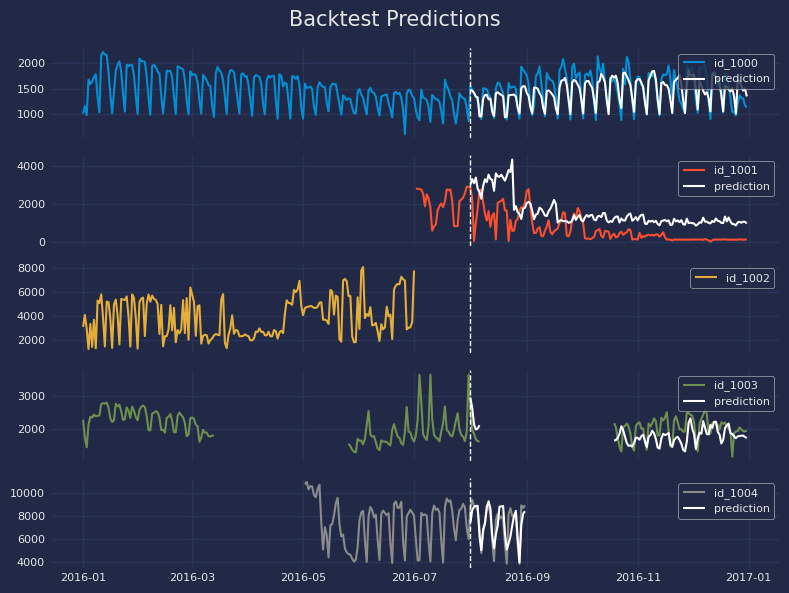

In [21]:
# Plot backtesting predictions
# ==============================================================================
fig, axs = plt.subplots(5, 1, figsize=(8, 6), sharex=True)

for i, s in enumerate(series_dict.keys()):
    axs[i].plot(series_dict[s], label=series_dict[s].name, color=colors[i])
    axs[i].axvline(pd.to_datetime(end_train), color='white', linestyle='--', linewidth=1)  # End train
    try:
        axs[i].plot(backtest_predictions[s], label='prediction', color="white")
    except:
        pass
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)

fig.suptitle('Backtest Predictions', fontsize=15)
plt.tight_layout()

# Advance use cases

Skforecast offers additional approaches to building global forecasting models:

<ul>
    <li>
    <a href="../user_guides/multi-series-with-different-length-and-different_exog.html">Global Forecasting Models: Time series with different lengths and different exogenous variables</a>
    </li>
    <li>
    <a href="../user_guides/dependent-multi-series-multivariate-forecasting.html">Global Forecasting Models: Dependent multi-series forecasting (Multivariate forecasting)</a>
    </li>
    <li>
    <a href="../user_guides/forecasting-with-deep-learning-rnn-lstm.html">Global Forecasting Models: Forecasting with Deep Learning</a>
    </li>
</ul>

To learn more about global forecasting models visit our examples:

<ul>
    <li>
    <a href="https://www.cienciadedatos.net/documentos/py44-multi-series-forecasting-skforecast.html">Global Forecasting Models: Multi-series forecasting with Python and skforecast</a>
    </li>
    <li>
    <a href="https://www.cienciadedatos.net/documentos/py59-scalable-forecasting-models.html">Scalable Forecasting: Modeling thousand time series with a single global model</a>
    </li>
    <li>
    <a href="https://cienciadedatos.net/documentos/py53-global-forecasting-models">Global Forecasting Models: Comparative Analysis of Single and Multi-Series Forecasting Modeling</a>
    </li>
    <li>
    <a href="https://cienciadedatos.net/documentos/py54-forecasting-with-deep-learning">Forecasting with Deep Learning</a>
    </li>
</ul>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by-nc-sa.svg" /></a><br/>

This work by  Joaquín Amat Rodrigo and Javier Escobar Ortiz is licensed under a <a rel="license" href="https://creativecommons.org/licenses/by-nc-sa/4.0/"> Attribution-NonCommercial-ShareAlike 4.0 International</a>.